In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from omegaconf import OmegaConf
from logutil import BaseLogger, parse_log

logg = BaseLogger("nb_debug")

from modeling import get_model

In [6]:
CONFIG_PATH = ### Your configuration file here

config = OmegaConf.load(CONFIG_PATH)
config.inference_mode = True
config.rank = 7
config.checkpoint = ### Your model checkpoint here
device = torch.device(config.rank)

In [ ]:
model = get_model(config, logg, inference_mode = config.inference_mode)
logg.info(f"Loading checkpoint: {config.checkpoint}")  
checkpoint = torch.load(config.checkpoint, map_location = torch.device(config.rank))
model.load_state_dict(checkpoint["model_state_dict"])

In [34]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(f"facebook/{config.esm_pretrained}")

def tokenize_sequence(s0, s1, config, tokenizer=tokenizer):
    t0 = tokenizer(s0, return_tensors="pt")["input_ids"].squeeze()
    t1 = tokenizer(s1, return_tensors="pt")["input_ids"].squeeze()
    return t0, t1

In [297]:
import pickle as pk

predictions_pk_file = ### Saved model predictions from `view_and_evaluate.ipynb`, used to find interactions to visualize
meta_data = pd.read_csv(config.META_DATA_FILE, sep = "\t", header=0)
sequences = SeqIO.to_dict(SeqIO.parse(config.TRAIN_SEQUENCES_FILE, "fasta"))

with open(predictions_pk_file,"rb") as f:
    test_preds = pk.load(f)
test_preds = pd.DataFrame({"label": test_preds[0], "pred": test_preds[1]})

best_ppi_pred = meta_data[meta_data["split"] == "test"].iloc[test_preds[test_preds.label == 1].pred.argmax()].name
meta_data.iloc[best_ppi_pred]

In [272]:
def get_attn_maps(tokens):
    mask = torch.ones_like(tokens).to(device)
    attention_no_lora = {}
    attention_with_lora = {}

    model.language_model.base_model.enable_adapter_layers()

    with torch.no_grad():
        x = model.language_model.base_model.model.embeddings(tokens.unsqueeze(0).to(device), attention_mask = mask)
        for layer_idx, layer in enumerate(model.language_model.base_model.model.encoder.layer):

            (x, attn) = layer.attention(x, output_attentions = True)
            attention_with_lora[layer_idx] = attn.squeeze().detach().cpu().numpy()

    model.language_model.base_model.disable_adapter_layers()

    with torch.no_grad():
        x = model.language_model.base_model.model.embeddings(tokens.unsqueeze(0).to(device), attention_mask = mask)
        for layer_idx, layer in enumerate(model.language_model.base_model.model.encoder.layer):

            (x, attn) = layer.attention(x, output_attentions = True)
            attention_no_lora[layer_idx] = attn.squeeze().detach().cpu().numpy()

    model.language_model.base_model.enable_adapter_layers()
    
    return attention_with_lora, attention_no_lora

In [359]:
# pr_i = best_ppi_pred
pr_i = 243284
n0, n1 = meta_data.iloc[pr_i].p0, meta_data.iloc[pr_i].p1
s0, s1 = meta_data.iloc[pr_i].s0, meta_data.iloc[pr_i].s1
t0, t1 = tokenize_sequence(s0, s1, config)

What do you want to name this file? o75438_nadh_dehydrogenase_sub1_attention_maps


Saving to ../figures/o75438_nadh_dehydrogenase_sub1_attention_maps.png


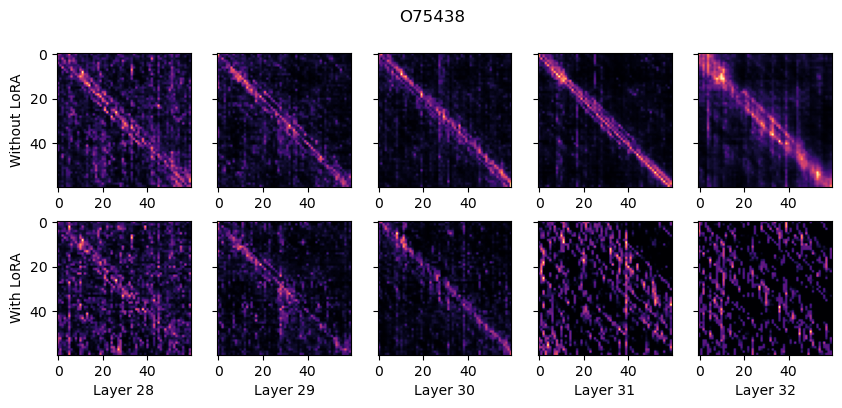

In [365]:
t0_with, t0_without = get_attn_maps(t0)

# First 27 are not adapted
# 28 29 30 31 32 are LoRA
layers_to_show = [28,29,30,31,32]
fig, ax = plt.subplots(2,len(layers_to_show), figsize = (10,4), sharey=True)

for i,l in enumerate(layers_to_show):
    ax[0, i].imshow(t0_without[l].mean(0),cmap="magma")
    ax[1, i].imshow(t0_with[l].mean(0),cmap="magma")
    ax[1, i].set_xlabel(f"Layer {l}")
ax[0, 0].set_ylabel("Without LoRA")
ax[1, 0].set_ylabel("With LoRA")
plt.suptitle(n0)
figname = input("What do you want to name this file?")
if figname != "":
    plt.savefig(f"../figures/{figname}.png",dpi=300,bbox_inches="tight")
    plt.savefig(f"../figures/{figname}.svg",dpi=300,bbox_inches="tight")
    print(f"Saving to ../figures/{figname}.png")
plt.show()

What do you want to name this file? o96000_nadh_dehydrogenase_sub10_attention_maps


Saving to ../figures/o96000_nadh_dehydrogenase_sub10_attention_maps.png


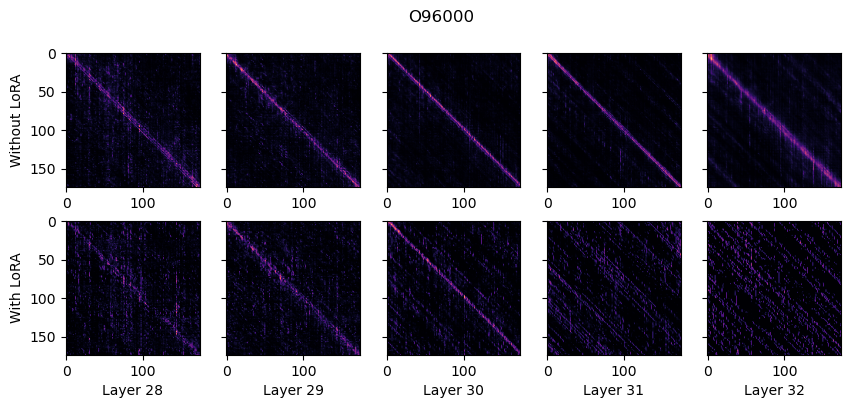

In [366]:
t1_with, t1_without = get_attn_maps(t1)

# First 27 are not adapted
# 28 29 30 31 32 are LoRA
layers_to_show = [28,29,30,31,32]
fig, ax = plt.subplots(2,len(layers_to_show), figsize = (10,4), sharey=True)

attention_with_lora, attention_no_lora = get_attn_maps(t1)

for i,l in enumerate(layers_to_show):
    ax[0, i].imshow(t1_without[l].mean(0),cmap="magma")
    ax[1, i].imshow(t1_with[l].mean(0),cmap="magma")
    ax[1, i].set_xlabel(f"Layer {l}")
ax[0, 0].set_ylabel("Without LoRA")
ax[1, 0].set_ylabel("With LoRA")
plt.suptitle(n1)
figname = input("What do you want to name this file?")
if figname != "":
    plt.savefig(f"../figures/{figname}.png",dpi=300,bbox_inches="tight")
    plt.savefig(f"../figures/{figname}.svg",dpi=300,bbox_inches="tight")
    print(f"Saving to ../figures/{figname}.png")
plt.show()